In [1]:
import os
import pickle
import numpy as np
import scipy.interpolate as spi
import matplotlib.pyplot as plt
%matplotlib inline

import flayer
import particle_evolution
import feo_thermodynamics as feot
import multiprocessing
import bulk_case_runner

# We have some annoying warnings - I think from llvm bug - fix then remove this
#import warnings
#warnings.filterwarnings("ignore")

## Cases corresponding to the five highlighted points on Figure 5

The difference is that the temperature, pressure and gravity change through the
200 km thick layer, and the composition is solved self-consistently with the total
solid volume (from all falling particles). 

The setup ends up giving us a much hotter layer (lower $\Delta \mu_{Fe}$) as we need
to intersect the liquidus at 200 km. A better comparison is probably T = 5700 K for
Figure 5 (not 5000 K) or reduce the amount of O, or make the layer thicker.

Temperature at CMB is 4225.944695087244 K
Temberature at top of F-layer is 5676.644650924955 K
Temberature at ICB is 5744.191075723928 K


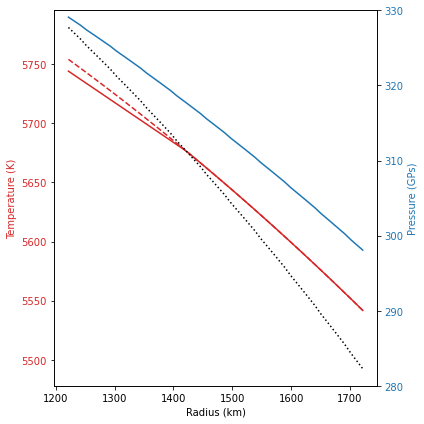


Corresponds to yellow square
Chemical diffusivity: 1e-09, kinematic viscosoity: 1.00e-06
Inner core growth rate is 17.5 km/Myr
Max vf_ratio is 7.46e-05
Max extra O in liquid 2.08e-04 % O by mass
Particle radii between 0.0271 and 9.56e-06 m
Particle radii between 0.0271 and 9.56e-06 m


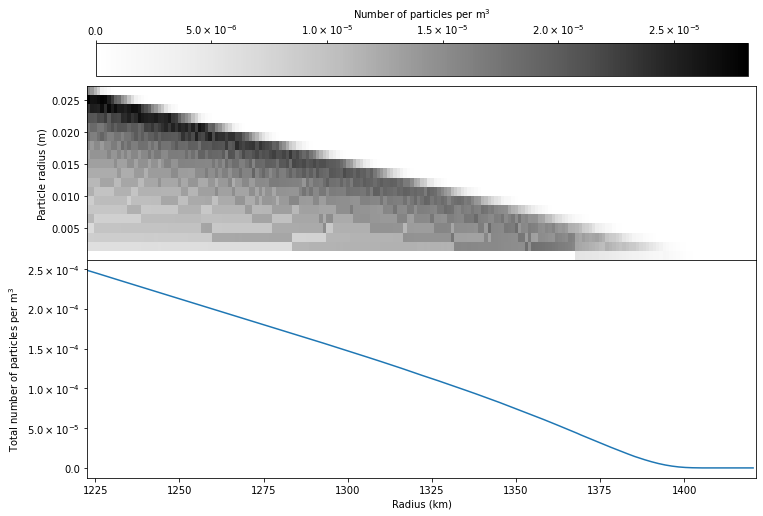

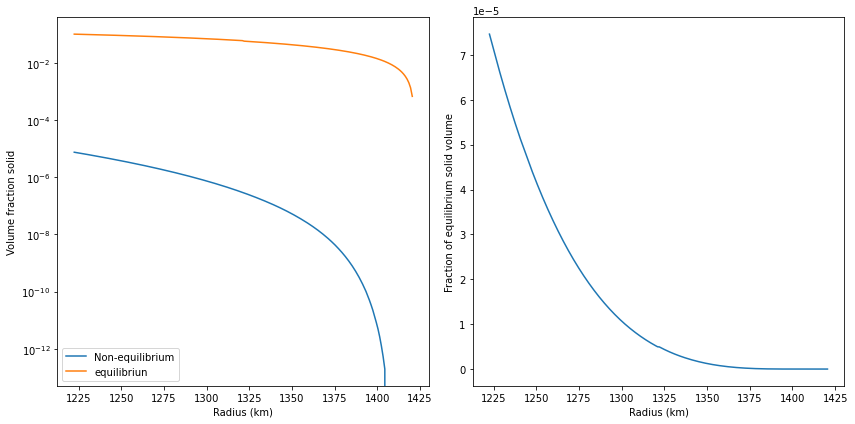


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++




Corresponds to red square
Chemical diffusivity: 1e-09, kinematic viscosoity: 5.00e-04
Inner core growth rate is 5.42 km/Myr
Max vf_ratio is 0.0003
Max extra O in liquid 8.37e-04 % O by mass
Particle radii between 0.017 and 4.52e-05 m
Particle radii between 0.017 and 4.52e-05 m


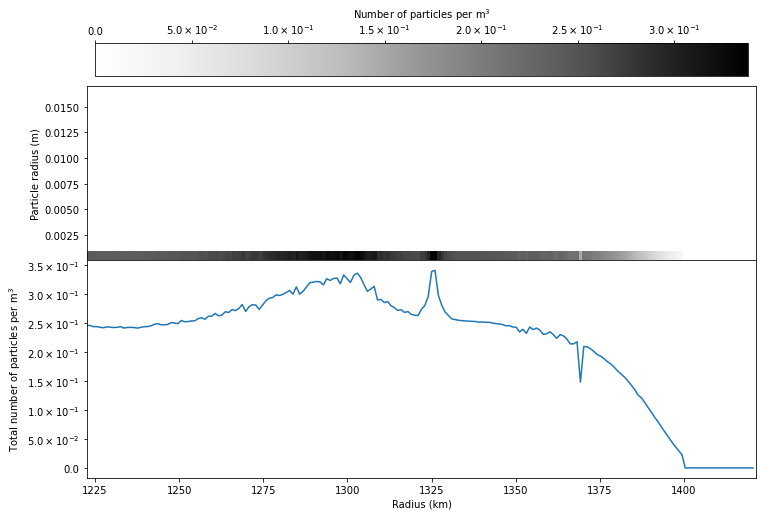

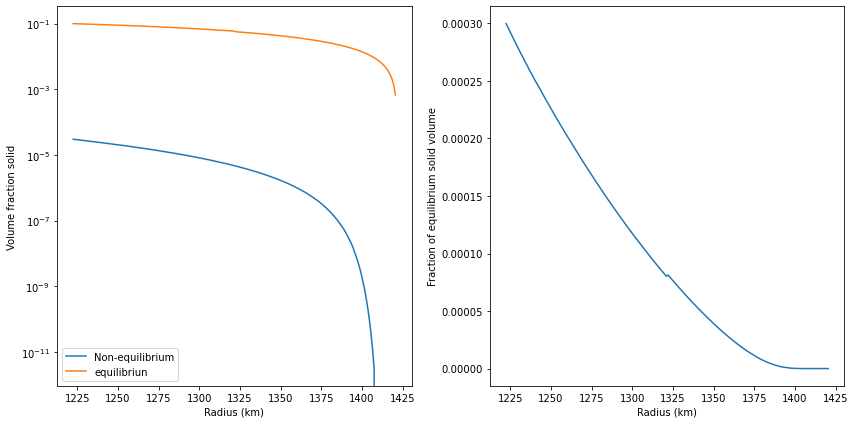


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++




Corresponds to orange square
Chemical diffusivity: 1e-09, kinematic viscosoity: 1.00e-07
Inner core growth rate is 132 km/Myr
Max vf_ratio is 0.000446
Max extra O in liquid 1.25e-03 % O by mass
Particle radii between 0.0535 and 5.38e-06 m
Particle radii between 0.0535 and 5.38e-06 m


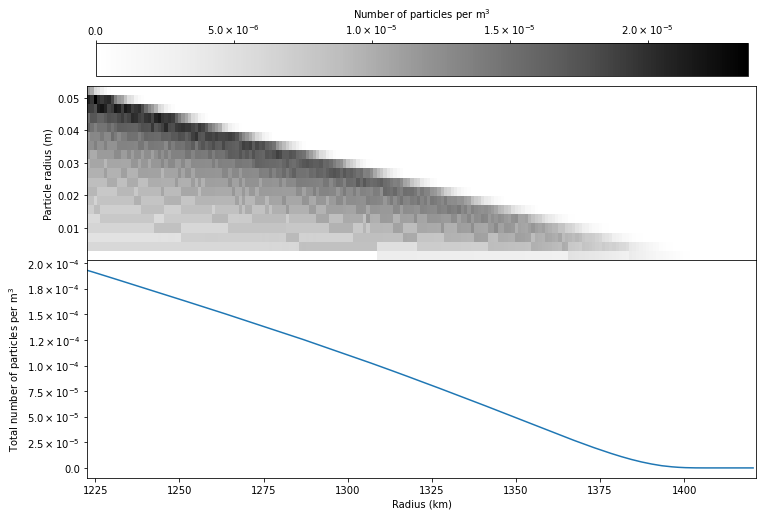

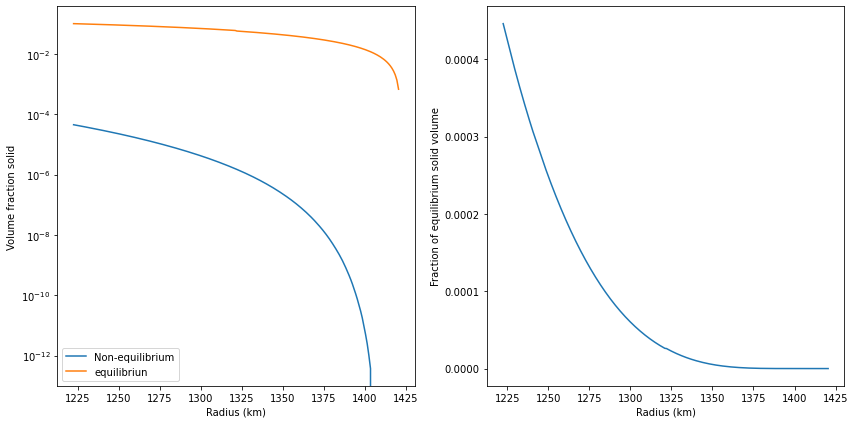


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++




Corresponds to light blue square
Chemical diffusivity: 1e-10, kinematic viscosoity: 1.00e-06
Inner core growth rate is 0.423 km/Myr
Max vf_ratio is 3.75e-06
Max extra O in liquid 1.04e-05 % O by mass
Particle radii between 0.00769 and 5.37e-06 m
Particle radii between 0.00769 and 5.37e-06 m


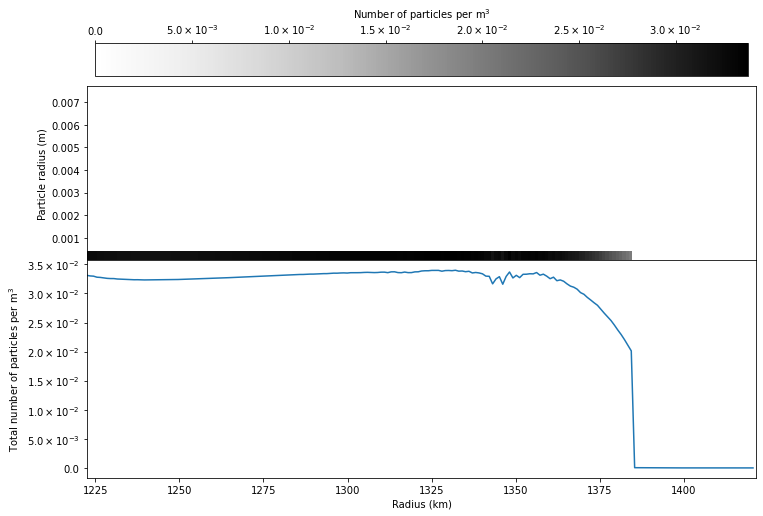

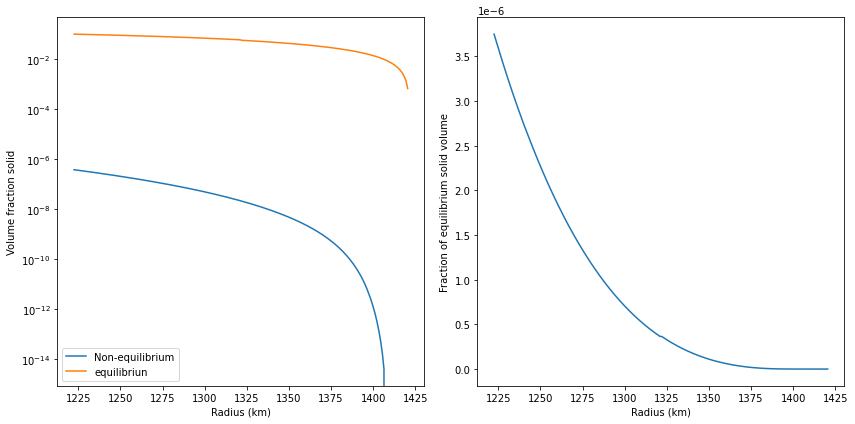


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++




Corresponds to dark blue square
Chemical diffusivity: 1e-08, kinematic viscosoity: 1.00e-06
Inner core growth rate is 909 km/Myr
Max vf_ratio is 0.0022
Max extra O in liquid 6.29e-03 % O by mass
Particle radii between 0.103 and 1.7e-05 m
Particle radii between 0.103 and 1.7e-05 m


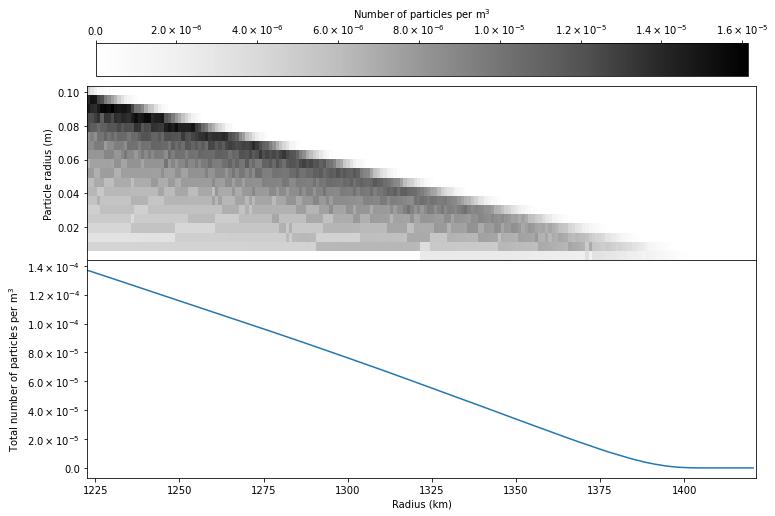

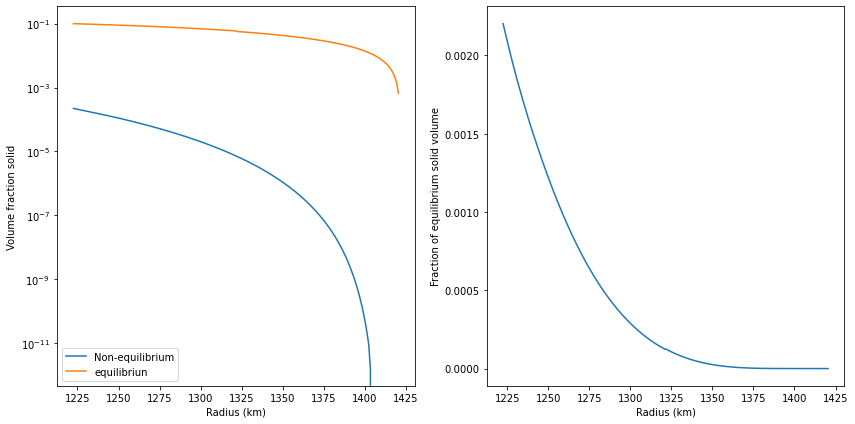


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++





In [2]:
parameters = {'f_layer_thickness': 200.0E3,
              'delta_t_icb': 10.0,
              'xfe_outer_core': 0.95,
              'xfe_icb': 0.95,
              'growth_prefactor': 150.0,
              'i0': 1.0E-10,
              'surf_energy': 1.08E-2, 
              'number_of_analysis_points': 200,
              'r_icb': 1221.5E3, 
              'r_cmb': 3480.0E3,
              'gruneisen_parameter': 1.5}

bulk_case_runner.plot_case_setup(**parameters)

# A set of five pairs of parameters. Tuples of (diffusivity, viscosity)
cases_diff_visc = ((1.0E-9, 1.0E-6), (1.0E-9, 5.0E-4), (1.0E-9, 1.0E-7), (1.0E-10, 1.0E-6), (1.0E-8, 1.0E-6))
cases_key = ("yellow square", "red square", "orange square", "light blue square", "dark blue square")
# Output lists
max_vf_ratio = []
icb_flux = []
max_particle_size = []
max_excess_oxygen_mass = []

# Just do runs in serial
for i, input_params in enumerate(cases_diff_visc):
    
    parameters['chemical_diffusivity'] = input_params[0]
    parameters['kinematic_viscosity'] = input_params[1]
    
    filename = f"cases/five-cases/case_{i}.pickle"
    if os.path.exists(filename):
        # We have this model run on disk. Just read...
        data = bulk_case_runner.load_case_data(filename)    
    else:
        # Run this model case
        data = bulk_case_runner.run_flayer_case(parameters, filename)
    
    print(f"\nCorresponds to {cases_key[i]}")
    print(f"Chemical diffusivity: {data['chemical_diffusivity']:.3g}, kinematic viscosoity: {data['kinematic_viscosity']:.2e}")
    print(f"Inner core growth rate is {data['growth_rate']:.3g} km/Myr")
    print(f"Max vf_ratio is {np.nanmax(data['vf_ratio']):.3g}")
    max_extra_o = np.max(feot.mass_percent_o(data["opt_xl"]) -  feot.mass_percent_o(data["xfe_outer_core"]))
    print(f"Max extra O in liquid {max_extra_o:.2e} % O by mass")
    max_particle_radius = data["particle_radii"][data["particle_radii"] > 0.0].max()
    min_particle_radius = data["particle_radii"][data["particle_radii"] > 0.0].min()
    print(f"Particle radii between {max_particle_radius:.3g} and {min_particle_radius:.3g} m")

    max_vf_ratio.append(np.nanmax(data['vf_ratio']))
    icb_flux.append(data["growth_rate"])
    max_particle_size.append(max_particle_radius)
    max_excess_oxygen_mass.append(max_extra_o)

    bulk_case_runner.plot_case_csd_nuc(**data)
    bulk_case_runner.plot_case_solid_frac(**data)
    print("\n+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\n\n")